_____________________
<h3><b>5. Logistic regression baseline</b></h3>

___________________

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import tensorflow as tf #tf version is 1.12
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [2]:
#import data
with np.load('features_mobilenet_v2.npz', allow_pickle=False) as npz_file:
    #features
    X_train = npz_file['train_hl']
    X_val = npz_file['validation_hl']
    X_test = npz_file['test_hl']
    #labels
    y_train = npz_file['labels_train']
    y_val = npz_file['labels_validation']
    y_test = npz_file['labels_test']
    #imgs
    train_imgs = npz_file['train_imgs']
    validation_imgs = npz_file['validation_imgs']
    test_imgs = npz_file['test_imgs']
    #paths
    train_imgs_path = npz_file['train_imgs_path']
    valid_imgs_path = npz_file['valid_imgs_path']
    test_imgs_path = npz_file['test_imgs_path']

________________
><h5><b>5.1. Fit the model</b></h5>

_____________

In [3]:
# Create the estimator
logreg_ovr = make_pipeline(StandardScaler(),
                       LogisticRegression(multi_class='ovr', solver='liblinear'))#note: by default c=1

# Fit it to train data
logreg_ovr.fit(X_train, y_train)

# Accuracy on test set
accuracy_logreg_ovr = logreg_ovr.score(X_test, y_test)
print('accuracy logistic regression (ovr): {:.2f}%'.format(accuracy_logreg_ovr))

accuracy logistic regression (ovr): 0.92%


________________
><h5><b>5.2. Gridsearch cross validation</b></h5>

_____________

The tuning is performed with cross-validated gridsearch using 5-fold strategy. To increase the amount of data the training and validation sets are merged for this specific task.

In [4]:
#combine train and val set
validation_train = np.concatenate((X_train, X_val), axis=0)
validation_test = np.concatenate((y_train, y_val), axis=0)

In [5]:
# define the pipeline
pipe_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [6]:
# Create cross-validation object
grid = {'logreg__C': np.logspace(-4, 4, num=10)}#check 10 C values
grid_cv = GridSearchCV(pipe_cv, grid, cv=5, return_train_score=True, n_jobs=-1)#n_jobs to maximize the speed

# Fit estimator
grid_cv.fit(validation_train, validation_test);

C:\Users\matfr\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
#collect result in a dataframe
cv_results = pd.DataFrame(grid_cv.cv_results_)

#print the most relevant columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_logreg__C']
tuned_logreg=cv_results[cols].sort_values('mean_test_score', ascending=False)
tuned_logreg

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
2,0.904535,0.027761,0.995224,0.001470,0.00599484
1,0.902148,0.023756,0.966006,0.005106,0.000774264
3,0.899761,0.018479,1.000000,0.000000,0.0464159
4,0.897375,0.018359,1.000000,0.000000,0.359381
5,0.897375,0.022138,1.000000,0.000000,2.78256
6,0.897375,0.022138,1.000000,0.000000,21.5443
7,0.894988,0.020764,1.000000,0.000000,166.81
9,0.892601,0.026721,1.000000,0.000000,10000
8,0.890215,0.020705,1.000000,0.000000,1291.55
0,0.887828,0.017347,0.931405,0.006593,0.0001


In [8]:
# fit the tuned pipeline

#extract the best C parameter for the new pipeline
C_tuned=tuned_logreg['param_logreg__C'].iloc[0]

tuned_logreg_ovr = make_pipeline(StandardScaler(),
                       LogisticRegression(C=C_tuned, multi_class='ovr', solver='liblinear'))#note: by default c=1

# Fit it to train data
tuned_logreg_ovr.fit(X_train, y_train)

# Accuracy on test set
tuned_accuracy_logreg_ovr = tuned_logreg_ovr.score(X_test, y_test)
print('accuracy tuned logistic regression (ovr): {:.2f}%'.format(tuned_accuracy_logreg_ovr))

accuracy tuned logistic regression (ovr): 0.98%


In [9]:
#append accuracy to models_summary.csv
models_summary = {'model': ['logistic'],
                  'test_accuracy': [tuned_accuracy_logreg_ovr]}
models_summary = pd.DataFrame(models_summary)

models_summary.to_csv("models_summary.csv", mode='a', index=False, header=False)#append to models_summary

_____________________
><h5><b>5.3. Class probability estimation</b></h5>

___________________

Here below I compute the probability for each class using based on my estimator.

In [10]:
#generate 10 random numbers (using random module) to select the images from the train set
import random
random.seed(10)#seed
rand_img_id = random.sample(range(279), 10)
rand_img_id

[16, 219, 247, 7, 105, 236, 251, 142, 82, 17]

In [11]:
#use np.take to extract the imgs corresponding to the rand_img_id
imgs_task = np.take(train_imgs, rand_img_id, axis=0)

#use np.take to extract the imgs paths
imgs_path = np.take(train_imgs_path, rand_img_id, axis=0)

In [12]:
#here I remove the path before the file name to clean the visualization
imgs_path = pd.DataFrame(imgs_path)#I convert the path in pd and again into np
imgs_names = imgs_path[0].str.split('\/').str[-1].str.strip()
imgs_names = np.array(imgs_names)
imgs_names

array(['bike-0017.png', 'truck-0007.png', 'truck-0035.png',
       'bike-0008.png', 'car-0040.png', 'truck-0024.png',
       'truck-0039.png', 'motorcycle-0013.png', 'car-0017.png',
       'bike-0018.png'], dtype=object)

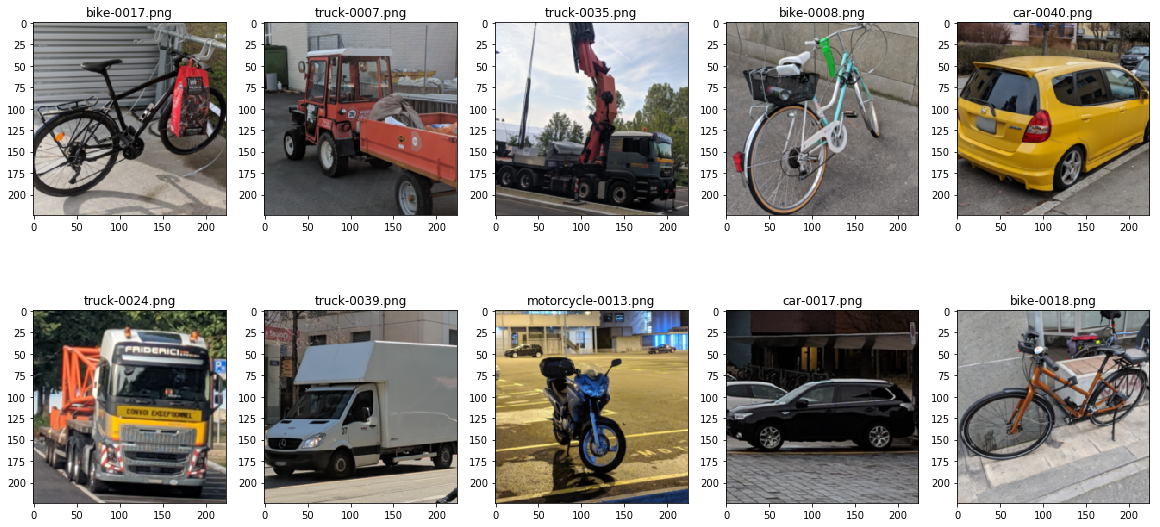

In [13]:
#plot 10 train images 
plt.figure(figsize=(20, 20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(0,10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(imgs_task[i])
    plt.title(imgs_names[i])

In [14]:
#store the probabilities as df
prob_df = tuned_logreg_ovr.predict_proba(X_train)
prob_df = pd.DataFrame(prob_df)

#filter the probabilities corresponding to the 10 images 
prob_df = prob_df.loc[rand_img_id]

#rename the columns
prob_df = prob_df.rename(columns={0: 'bike',
                                  1: 'car', 
                                  2: 'motorcycle', 
                                  3: 'other', 
                                  4: 'truck', 
                                  5: 'van' })

#rename the index with the corresponding image
prob_df.index = imgs_names

#round the decimals
prob_df = prob_df.round(decimals=2)

#display the df as heatmap to ease the visualization
prob_df.style.background_gradient(cmap ='viridis', axis=1)

,bike,car,motorcycle,other,truck,van
bike-0017.png,0.49,0.05,0.09,0.16,0.07,0.14
truck-0007.png,0.02,0.05,0.05,0.33,0.41,0.13
truck-0035.png,0.04,0.05,0.04,0.3,0.46,0.11
bike-0008.png,0.49,0.07,0.13,0.11,0.07,0.12
car-0040.png,0.05,0.5,0.04,0.14,0.1,0.16
truck-0024.png,0.04,0.04,0.05,0.18,0.49,0.21
truck-0039.png,0.05,0.03,0.09,0.1,0.53,0.2
motorcycle-0013.png,0.13,0.03,0.49,0.12,0.14,0.1
car-0017.png,0.02,0.51,0.08,0.19,0.08,0.12
bike-0018.png,0.49,0.04,0.12,0.1,0.07,0.17


Here below I test 4 different regularization strengths based on the tuned C (i.e. C_tuned/10, C_tuned/100, C_tuned*10, C_tuned*100). To show the regularization impact I will plot the probability across the different classes of the first image of the previous dataframe (bike-0017.png).

In [15]:
#vary the C parameter
#C=C_tuned/10
tuned_logreg_ovr.set_params(logisticregression__C=C_tuned/10)#vary param C
tuned_logreg_ovr.fit(X_train, y_train)#refit model
prob_df_C_div10 = pd.DataFrame(tuned_logreg_ovr.predict_proba(X_train))#save prob as df
prob_df_C_div10 = prob_df_C_div10.loc[rand_img_id]#extract proper images
prob_df_C_div10 = prob_df_C_div10.rename(columns={0: 'bike', 1: 'car', 2: 'motorcycle', 3: 'other', 4: 'truck', 5: 'van' })#rename columns
prob_df_C_div10.index = imgs_names#rename indexes

#C=C_tuned/100
tuned_logreg_ovr.set_params(logisticregression__C=C_tuned/100)
tuned_logreg_ovr.fit(X_train, y_train)
prob_df_C_div100 = pd.DataFrame(tuned_logreg_ovr.predict_proba(X_train))
prob_df_C_div100 = prob_df_C_div100.loc[rand_img_id]
prob_df_C_div100 = prob_df_C_div100.rename(columns={0: 'bike', 1: 'car', 2: 'motorcycle', 3: 'other', 4: 'truck', 5: 'van' })
prob_df_C_div100.index = imgs_names

#C=C_tuned*10
tuned_logreg_ovr.set_params(logisticregression__C=C_tuned*10)
tuned_logreg_ovr.fit(X_train, y_train)
prob_df_C_mul10 = pd.DataFrame(tuned_logreg_ovr.predict_proba(X_train))
prob_df_C_mul10 = prob_df_C_mul10.loc[rand_img_id]
prob_df_C_mul10 = prob_df_C_mul10.rename(columns={0: 'bike', 1: 'car', 2: 'motorcycle', 3: 'other', 4: 'truck', 5: 'van' })
prob_df_C_mul10.index = imgs_names

#C=C_tuned*100
tuned_logreg_ovr_C_div100 = tuned_logreg_ovr.set_params(logisticregression__C=C_tuned*100)
tuned_logreg_ovr.fit(X_train, y_train)
prob_df_C_mul100 = pd.DataFrame(tuned_logreg_ovr.predict_proba(X_train))
prob_df_C_mul100 = prob_df_C_mul100.loc[rand_img_id]
prob_df_C_mul100 = prob_df_C_mul100.rename(columns={0: 'bike', 1: 'car', 2: 'motorcycle', 3: 'other', 4: 'truck', 5: 'van' })
prob_df_C_mul100.index = imgs_names

#create a list with the different prob dataframes
prob_image_1=pd.concat([prob_df_C_div100[0:1],
                        prob_df_C_div10[0:1],
                        prob_df[0:1],#this one is the original C_tuned 
                        prob_df_C_mul10[0:1],
                        prob_df_C_mul100[0:1]], axis=0)

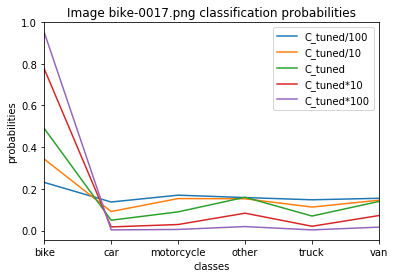

In [16]:
#plot the classification prbabilities for the image
#define legend labels
labels = ['C_tuned/100','C_tuned/10', 'C_tuned','C_tuned*10','C_tuned*100']

prob_image_1.T.plot()#with this I plot each row of the df as line
plt.title('Image bike-0017.png classification probabilities')
plt.legend(labels=labels) 
plt.xlabel('classes')
plt.ylabel('probabilities');

Varying the C parameter changes the bias-variance trade-off. Decreasing the C parameter leads to a worse classification performance (blue and orange lines) compared to the tuned C, i.e. less discrimination across categories. Differently, increasing C leads to a very high probability for one only class.